### Import libraries

In [1]:
import numpy as np
import cmath
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import quad
import yfinance as yf

### Download stock and options data

In [21]:
ticker = "AAPL"
stock = yf.Ticker(ticker)

# Choose second-longest expiry (if available), else use the first
exp_date = stock.options[1]

opt_chain = stock.option_chain(exp_date)
calls = opt_chain.calls
calls.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,AAPL251128C00110000,2025-11-06 15:22:28+00:00,110.0,160.95,161.30,164.35,0.0,0.0,NaN,8,2.244145,True,REGULAR,USD
1,AAPL251128C00120000,2025-11-05 17:41:07+00:00,120.0,150.80,150.85,154.40,0.0,0.0,NaN,6,1.869141,True,REGULAR,USD
2,AAPL251128C00125000,2025-11-05 17:54:19+00:00,125.0,145.77,145.80,149.20,0.0,0.0,NaN,2,1.605471,True,REGULAR,USD
3,AAPL251128C00130000,2025-11-06 15:22:28+00:00,130.0,141.01,140.85,144.40,0.0,0.0,NaN,5,1.699220,True,REGULAR,USD
4,AAPL251128C00135000,2025-11-05 17:41:07+00:00,135.0,135.81,135.80,139.40,0.0,0.0,NaN,2,1.593752,True,REGULAR,USD


In [27]:
# Get current stock price
price = stock.info.get('currentPrice') 
price

272.41

In [29]:
risk_free_rate = 0.04  # 4%

### Prepare options data for calibration

In [31]:
exp_dt = pd.to_datetime(exp_date)
today = pd.to_datetime('today').normalize()
tau = (exp_dt - today).days / 365.25

# Filter for liquid call options
calls = calls[(calls['openInterest'] > 0) & 
              (calls['lastPrice'] > 0.1) & 
              (calls['volume'] > 0)].copy()

calls.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
6,AAPL251128C00145000,2025-11-12 16:43:13+00:00,145.0,129.78,125.80,129.45,0.0,0.0,1.0,2,1.468753,True,REGULAR,USD
9,AAPL251128C00160000,2025-11-05 17:25:01+00:00,160.0,109.91,110.90,114.45,0.0,0.0,68.0,10,1.294925,True,REGULAR,USD
13,AAPL251128C00185000,2025-11-07 19:56:24+00:00,185.0,83.14,86.45,88.60,0.0,0.0,2.0,3,0.871095,True,REGULAR,USD
14,AAPL251128C00190000,2025-11-07 19:51:53+00:00,190.0,78.21,81.40,84.00,0.0,0.0,2.0,9,0.927735,True,REGULAR,USD
15,AAPL251128C00195000,2025-11-10 20:00:53+00:00,195.0,75.05,75.90,79.50,0.0,0.0,14.0,3,0.869142,True,REGULAR,USD


In [33]:
calls['impliedVolatility'] = calls['impliedVolatility'].replace(0, np.nan).fillna(0.3)
calls.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
6,AAPL251128C00145000,2025-11-12 16:43:13+00:00,145.0,129.78,125.80,129.45,0.0,0.0,1.0,2,1.468753,True,REGULAR,USD
9,AAPL251128C00160000,2025-11-05 17:25:01+00:00,160.0,109.91,110.90,114.45,0.0,0.0,68.0,10,1.294925,True,REGULAR,USD
13,AAPL251128C00185000,2025-11-07 19:56:24+00:00,185.0,83.14,86.45,88.60,0.0,0.0,2.0,3,0.871095,True,REGULAR,USD
14,AAPL251128C00190000,2025-11-07 19:51:53+00:00,190.0,78.21,81.40,84.00,0.0,0.0,2.0,9,0.927735,True,REGULAR,USD
15,AAPL251128C00195000,2025-11-10 20:00:53+00:00,195.0,75.05,75.90,79.50,0.0,0.0,14.0,3,0.869142,True,REGULAR,USD


In [35]:
options_data = pd.DataFrame({
    'strike': calls['strike'],
    'market_price': calls['lastPrice'],
    'maturity': tau,
    'rate': risk_free_rate,
    'implied_vol': calls['impliedVolatility']
})
options_data.head()

,strike,market_price,maturity,rate,implied_vol
6,145.0,129.78,0.032854,0.04,1.468753
9,160.0,109.91,0.032854,0.04,1.294925
13,185.0,83.14,0.032854,0.04,0.871095
14,190.0,78.21,0.032854,0.04,0.927735
15,195.0,75.05,0.032854,0.04,0.869142


In [37]:
print("Current Price: %.2f" % price)
print("Expiry:", exp_date, "(T = %.4f years)" % tau)
print("Number of options:", len(options_data))

Current Price: 272.41
Expiry: 2025-11-28 (T = 0.0329 years)
Number of options: 38


### Heston Model Characteristic Function

#### Inputs
- $\large S$: spot price
- $\large v_0$: initial variance
- $\large \kappa$: mean reversion speed
- $\large \theta$: long-run variance
- $\large \sigma$: volatility of variance
- $\large \rho$: correlation
- $\large T$: time to maturity
- $\large r$: risk-free rate
- $\large \phi$: characteristic function parameter

#### Auxiliary Terms
- $\large a = \kappa\theta$
- $\large b = \kappa$
- $\large \text{term}_1 = \rho\sigma\phi i$
- $\large d = \sqrt{(\text{term}_1 - b)^2 + (\phi i + \phi^2)\sigma^2}$
- $\large g = \frac{b - \text{term}_1 + d}{b - \text{term}_1 - d}$

#### Exponential Components
- $\large \exp_1 = e^{i\phi(\ln S + rT)}$
- $\large \exp_2 = \left( \frac{1 - ge^{dT}}{1 - g} \right)^{-\frac{2a}{\sigma^2}}$
- $\large \exp_3 = \exp\left( \frac{a(b - \text{term}_1 + d)T}{\sigma^2} + \frac{v_0(b - \text{term}_1 + d)(1 - e^{dT})}{\sigma^2(1 - ge^{dT})} \right)$

#### Final Characteristic Function
- $\large \varphi(\phi) = \exp_1 \cdot \exp_2 \cdot \exp_3$

### Calibration setup

In [60]:
S0 = price

def heston_charfunc(phi, S, v0, kappa, theta, sigma, rho, T, r):
    a = kappa * theta
    b = kappa
    term1 = rho * sigma * phi * 1j
    d = cmath.sqrt((term1 - b)**2 + (phi * 1j + phi**2) * sigma**2)
    g = (b - term1 + d) / (b - term1 - d)
    exp1 = np.exp(1j * phi * (np.log(S) + r*T))
    exp2 = ((1 - g * np.exp(d*T)) / (1 - g)) ** (-2*a / sigma**2)
    exp3 = np.exp((a * (b - term1 + d)*T) / sigma**2 + 
                  (v0 * (b - term1 + d)*(1 - np.exp(d*T))) / 
                  (sigma**2 * (1 - g * np.exp(d*T))))
    return exp1 * exp2 * exp3

### Heston Model Option Pricing

#### Integrand in the Heston Formula:

#### Numerator
- $\large \text{num} = e^{rT} \varphi (\phi - i) - K \varphi (\phi)$

#### Denominator
- $\large \text{den} = i \phi K^{i \phi}$

#### Integrand
- $\large f(\phi) = \Re \left( \frac{\text{num}}{\text{den}} \right)$

In [62]:
def integrand(phi, S, v0, kappa, theta, sigma, rho, T, r, K):
    numerator = np.exp(r*T) * heston_charfunc(phi - 1j, S, v0, kappa, theta, sigma, rho, T, r) - K * heston_charfunc(phi, S, v0, kappa, theta, sigma, rho, T, r)
    denominator = 1j * phi * (K ** (1j * phi))
    return np.real(numerator / denominator)

### Heston Call Price Formula

#### Integral Term
- $\large I = \int_{0}^{100} f(\phi) d\phi$

#### Full Price
- $\large C = \frac{1}{2} (S - Ke^{-rT}) + \frac{I}{\pi}$

#### Intrinsic-Value Floor
- $\large C = \max (C, S - Ke^{-rT})$

In [67]:
def heston_price(S, K, v0, kappa, theta, sigma, rho, T, r):
    integral_value, _ = quad(integrand, 0, 100, args=(S, v0, kappa, theta, sigma, rho, T, r, K))
    price = 0.5 * (S - K * np.exp(-r * T)) + integral_value / np.pi
    return max(price, S - K * np.exp(-r * T))

### Define the calibration objective

In [41]:
def objective(params):
    v0, kappa, theta, sigma, rho = params
    # Penalize impossible values
    if v0 <= 0 or kappa <= 0 or theta <= 0 or sigma <= 0 or rho <= -1 or rho >= 1:
        return 1e10
    errors = []
    for _, row in options_data.iterrows():
        try:
            model_price = heston_price(S0, row['strike'], v0, kappa, theta, sigma, rho, row['maturity'], row['rate'])
            error = (row['market_price'] - model_price) ** 2
            errors.append(error)
        except:
            errors.append(1e6)
    return np.sum(errors)

### Run the calibration

In [43]:
initial_guess = [0.04, 2.0, 0.04, 0.3, -0.7]
bounds = [
    (0.001, 0.5),    # v0
    (0.1, 10.0),     # kappa
    (0.01, 0.5),     # theta
    (0.1, 1.0),      # sigma
    (-0.99, 0.0)     # rho
]

result = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B', options={'maxiter': 500})

In [45]:
if result.success:
    v0_cal, kappa_cal, theta_cal, sigma_cal, rho_cal = result.x
    print("\nCalibrated Parameters:")
    print("v0 (initial variance) = %.4f" % v0_cal)
    print("kappa (mean reversion) = %.4f" % kappa_cal)
    print("theta (long-term variance) = %.4f" % theta_cal)
    print("sigma (vol of vol) = %.4f" % sigma_cal)
    print("rho (correlation) = %.4f" % rho_cal)
    print("Final objective value: %.4f" % result.fun)
else:
    print("Optimization failed:", result.message)
    v0_cal, kappa_cal, theta_cal, sigma_cal, rho_cal = result.x


Calibrated Parameters:
v0 (initial variance) = 0.0639
kappa (mean reversion) = 0.1000
theta (long-term variance) = 0.0100
sigma (vol of vol) = 1.0000
rho (correlation) = -0.7788
Final objective value: 101.1150


### Calculate model prices

In [47]:
options_data['model_price'] = [heston_price(
    S0, row['strike'], v0_cal, kappa_cal, theta_cal, sigma_cal, rho_cal, row['maturity'], row['rate']
) for _, row in options_data.iterrows()]

### Calculate fit metrics

In [49]:
market_prices = options_data['market_price']
model_prices = options_data['model_price']
mape = np.mean(np.abs((market_prices - model_prices) / market_prices)) * 100
rmse = np.sqrt(np.mean((market_prices - model_prices) ** 2))

print("\nCalibration Quality:")
print("RMSE: %.4f" % rmse)
print("MAPE: %.2f%%" % mape)


Calibration Quality:
RMSE: 1.6312
MAPE: 16.15%


### Plot results

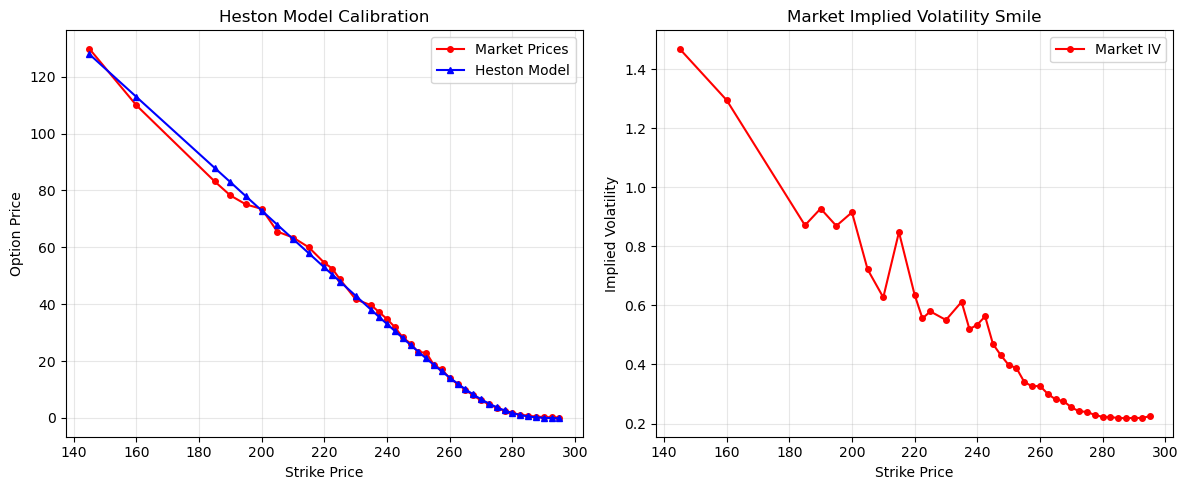

In [53]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(options_data['strike'], options_data['market_price'], 'ro-', label='Market Prices', markersize=4)
plt.plot(options_data['strike'], options_data['model_price'], 'b^-', label='Heston Model', markersize=4)
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.title('Heston Model Calibration')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(options_data['strike'], options_data['implied_vol'], 'ro-', label='Market IV', markersize=4)
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('Market Implied Volatility Smile')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

### Print first 10 results

In [55]:
print("\nSample Results (First 10 options):")
print(options_data[['strike', 'market_price', 'model_price', 'implied_vol']].head(10))


Sample Results (First 10 options):
    strike  market_price  model_price  implied_vol
6    145.0        129.78   127.868437     1.468753
9    160.0        109.91   112.864787     1.294925
13   185.0         83.14    87.886217     0.871095
14   190.0         78.21    82.901946     0.927735
15   195.0         75.05    77.884417     0.869142
16   200.0         73.50    72.911649     0.915040
17   205.0         65.50    67.896713     0.721682
18   210.0         63.43    62.904320     0.626957
19   215.0         60.00    57.921649     0.848146
20   220.0         54.53    52.903122     0.635746
